In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import splprep
import scipy.stats
import pickle
import pandas as pd
import math

In [2]:
plt.style.use("seaborn-v0_8")

## Load and combine raw data from all three batches

In [3]:
batch1 = pickle.load(open(r'..\Data\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [4]:
numBat1 = len(batch1.keys())
numBat1

41

In [5]:
batch2 = pickle.load(open(r'..\Data\batch2.pkl','rb'))

In [6]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [7]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [8]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [9]:
numBat2 = len(batch2.keys())
numBat2

43

In [10]:
batch3 = pickle.load(open(r'..\Data\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [11]:
numBat3 = len(batch3.keys())
numBat3

40

In [12]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [13]:
bat_dict = {**batch1, **batch2, **batch3}

In [14]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat)

In [15]:
print("Test ind: ", test_ind)
print("Train ind: ", train_ind)
print("Secondary test ind: ", secondary_test_ind)

Test ind:  [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46
 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 83]
Train ind:  [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47
 49 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79 81]
Secondary test ind:  [ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123]


## Calculate $\Delta Q$ features

In [24]:
def get_var(id,i,j):
    diff = bat_dict[id]["cycles"][j]["Qdlin"]-bat_dict[id]["cycles"][i]["Qdlin"]
    return np.log10(np.var(diff))

def get_min(id,i,j):
    diff = bat_dict[id]["cycles"][j]["Qdlin"]-bat_dict[id]["cycles"][i]["Qdlin"]
    return np.min(diff)

def get_mean(id,i,j):
    diff = bat_dict[id]["cycles"][j]["Qdlin"]-bat_dict[id]["cycles"][i]["Qdlin"]
    return np.mean(diff)

def get_skew(id,i,j):
    diff = bat_dict[id]["cycles"][j]["Qdlin"]-bat_dict[id]["cycles"][i]["Qdlin"]
    return scipy.stats.skew(diff)

def get_kurt(id,i,j):
    diff = bat_dict[id]["cycles"][j]["Qdlin"]-bat_dict[id]["cycles"][i]["Qdlin"]
    return scipy.stats.kurtosis(diff)

In [57]:
def check_outliers(series, thres):
    idxs = np.where(series > thres)
    print(series[idxs])
    series[idxs] = (series[idxs-1] + series[idx+1])/2
    return series

In [55]:
check_outliers(np.array(logVars),-2)

TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

## Build dictionary

In [28]:
feature_dict = {}
for id in bat_dict.keys():
    feature_dict[id] = {"cycle_life":bat_dict[id]["cycle_life"][0][0]}

In [26]:
x = np.arange(2,100,1)

In [29]:
for id in bat_dict.keys():
    logVars = []
    mins = []
    means = []
    temp_maxs = []
    temp_vars = []
    deltaIRs = []
    #skews = []
    #kurts = []
    #cs_1 = interpolate_spline_cycle(id,"10")
    for j in x:
        var = get_var(id,"1",str(j))
        logVars.append(var)

        min = get_min(id,"1",str(j))
        mins.append(min)

        mean = get_mean(id,"1",str(j))
        means.append(mean)

        temp_max = bat_dict[id]["summary"]["Tmax"][j]-bat_dict[id]["summary"]["Tmax"][1]
        temp_maxs.append(temp_max)

        temp_var = np.log10(np.var(bat_dict[id]["cycles"][str(j)]["Tdlin"]-bat_dict[id]["cycles"]["1"]["Tdlin"]))
        temp_vars.append(temp_var)

        deltaIR = bat_dict[id]["summary"]["IR"][j]-bat_dict[id]["summary"]["IR"][1]
        deltaIRs.append(deltaIR)
        #skew = get_skew(id,cs_1,cs_2)
        #skews.append(skew)
        #kurt = get_kurt(id,cs_1,cs_2)
        #kurts.append(kurt)
    feature_dict[id]["DeltaQ_logVars"] = np.array(logVars)
    feature_dict[id]["DeltaQ_mins"] = np.array(mins)
    feature_dict[id]["DeltaQ_means"] = np.array(means)
    feature_dict[id]["DeltaT_max"] = np.array(temp_maxs)
    feature_dict[id]["DeltaT_logVars"] = np.array(temp_vars)
    feature_dict[id]["DeltaIR"] = np.array(deltaIRs)
    #feature_dict[id]["DeltaQ_skews"] = np.array(skews)
    #feature_dict[id]["DeltaQ_kurts"] = np.array(kurts)

In [30]:
feature_df = pd.DataFrame.from_dict(feature_dict,orient="index")

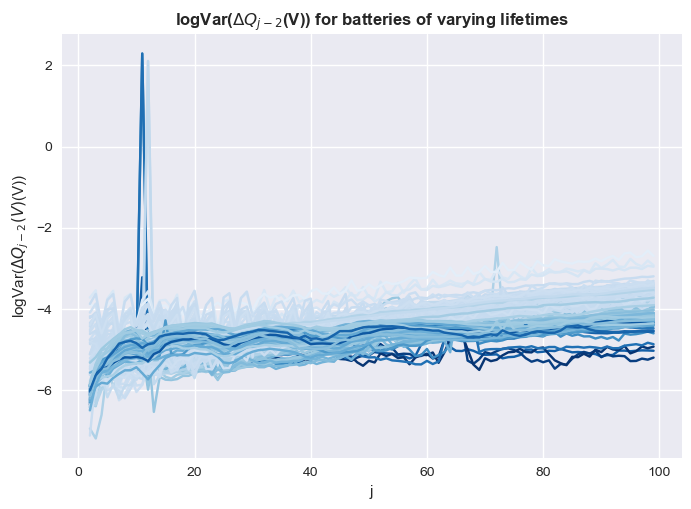

In [43]:
fig,ax=plt.subplots()
colors = plt.cm.Blues(np.linspace(0.1,1,len(bat_dict.keys())))
for id in bat_dict.keys():
    ix = int(len(colors)*(feature_dict[id]['cycle_life']-150)/(2300-150))
    y = feature_dict[id]['DeltaQ_logVars']
    #y = gaussian_filter(y,sigma=3)
    ax.plot(x,y,color=colors[ix])
    ax.set_title("logVar($\Delta Q_{j-2}$(V)) for batteries of varying lifetimes",fontweight='bold')
    ax.set_xlabel("j")
    ax.set_ylabel("logVar($\Delta Q_{j-2}(V)$(V))")
    #ax.set_ylim([-6.5,-2.5])

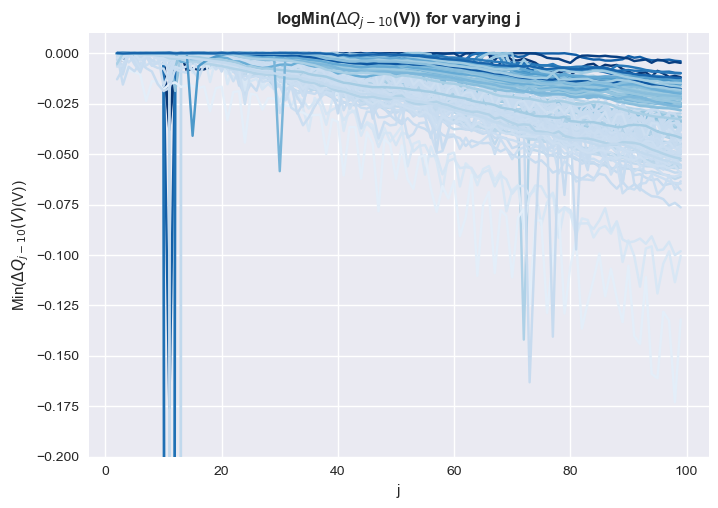

In [38]:
fig,ax=plt.subplots()
colors = plt.cm.Blues(np.linspace(0.1,1,len(bat_dict.keys())))
for id in bat_dict.keys():
    ix = int(len(colors)*(feature_dict[id]['cycle_life']-150)/(2300-150))
    #y = np.log10(-feature_dict[id]['DeltaQ_mins'])
    y = feature_dict[id]['DeltaQ_mins']
    #y = gaussian_filter(y,sigma=2)
    ax.plot(x,y,color=colors[ix])
    ax.set_title("logMin($\Delta Q_{j-10}$(V)) for varying j",fontweight='bold')
    ax.set_xlabel("j")
    ax.set_ylabel("Min($\Delta Q_{j-10}(V)$(V))")
    ax.set_ylim([-0.2,0.01])

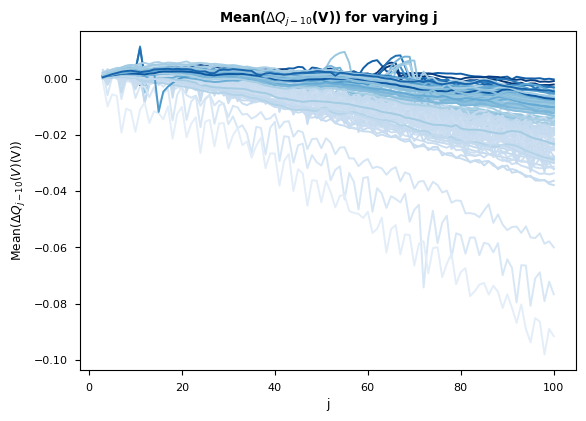

In [26]:
fig,ax=plt.subplots()
colors = plt.cm.Blues(np.linspace(0.1,1,len(bat_dict.keys())))
for id in bat_dict.keys():
    ix = int(len(colors)*(feature_dict[id]['cycle_life']-150)/(2300-150))
    y = feature_dict[id]['DeltaQ_means']
    #y = gaussian_filter(y,sigma=2)
    ax.plot(x,y,color=colors[ix])
    ax.set_title("Mean($\Delta Q_{j-10}$(V)) for varying j",fontweight='bold')
    ax.set_xlabel("j")
    ax.set_ylabel("Mean($\Delta Q_{j-10}(V)$(V))")

In [ ]:
fig,ax=plt.subplots()
colors = plt.cm.Blues(np.linspace(0.1,1,len(bat_dict.keys())))
for id in bat_dict.keys():
    ix = int(len(colors)*(feature_dict[id]['cycle_life']-150)/(2300-150))
    y = feature_dict[id]['DeltaQ_skews']
    #y = gaussian_filter(y,sigma=3)
    ax.plot(x,y,color=colors[ix])
    ax.set_title("Skew($\Delta Q_{j-10}$(V)) for varying j",fontweight='bold')
    ax.set_xlabel("j")
    ax.set_ylabel("Skew($\Delta Q_{j-10}(V)$(V))")

In [ ]:
fig,ax=plt.subplots()
colors = plt.cm.Blues(np.linspace(0.1,1,len(bat_dict.keys())))
for id in bat_dict.keys():
    ix = int(len(colors)*(feature_dict[id]['cycle_life']-150)/(2300-150))
    y = feature_dict[id]['DeltaQ_kurts']
    #y = gaussian_filter(y,sigma=3)
    ax.plot(x,y,color=colors[ix])
    ax.set_title("Kurt($\Delta Q_{j-10}$(V)) for varying j",fontweight='bold')
    ax.set_xlabel("j")
    ax.set_ylabel("Kurt($\Delta Q_{j-10}(V)$(V))")

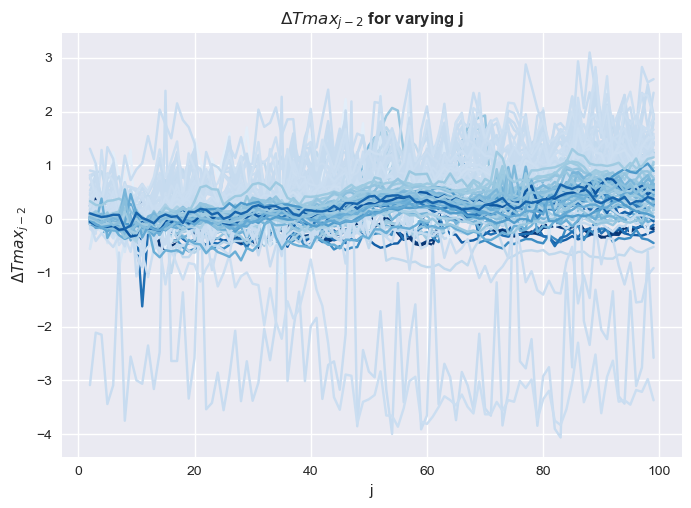

In [39]:
fig,ax=plt.subplots()
colors = plt.cm.Blues(np.linspace(0.1,1,len(bat_dict.keys())))
for id in bat_dict.keys():
    ix = int(len(colors)*(feature_dict[id]['cycle_life']-150)/(2300-150))
    y = feature_dict[id]['DeltaT_max']
    #y = gaussian_filter(y,sigma=3)
    ax.plot(x,y,color=colors[ix])
    ax.set_title("$\Delta Tmax_{j-2}$ for varying j",fontweight='bold')
    ax.set_xlabel("j")
    ax.set_ylabel("$\Delta Tmax_{j-2}$")

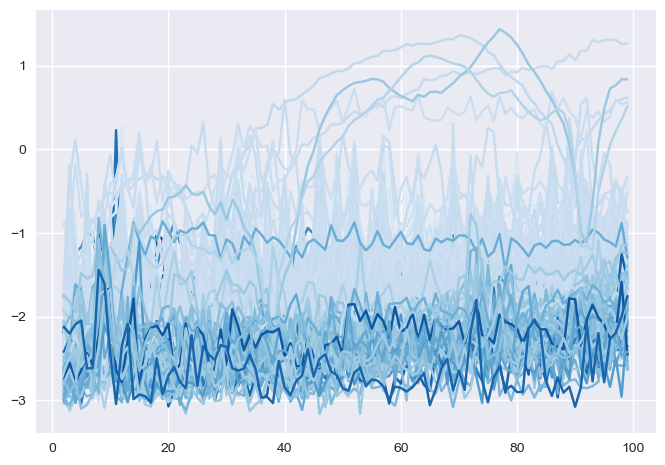

In [40]:
fig,ax=plt.subplots()
colors = plt.cm.Blues(np.linspace(0.1,1,len(bat_dict.keys())))
for id in bat_dict.keys():
    ix = int(len(colors)*(feature_dict[id]['cycle_life']-150)/(2300-150))
    y = feature_dict[id]['DeltaT_logVars']
    #y = gaussian_filter(y,sigma=3)
    ax.plot(x,y,color=colors[ix])

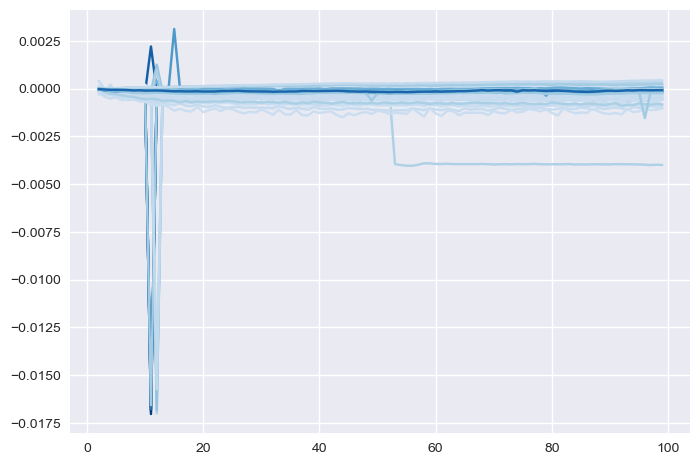

In [41]:
fig,ax=plt.subplots()
colors = plt.cm.Blues(np.linspace(0.1,1,len(bat_dict.keys())))
for id in bat_dict.keys():
    ix = int(len(colors)*(feature_dict[id]['cycle_life']-150)/(2300-150))
    y = feature_dict[id]['DeltaIR']
    #y = gaussian_filter(y,sigma=3)
    ax.plot(x,y,color=colors[ix])

In [42]:
with open('../Data/sev_deltaQ_cycles.pkl','wb') as fp:
    pickle.dump(feature_dict,fp)

## Load data

In [22]:
feature_df = pd.DataFrame.from_dict(feature_dict,orient='index')
feature_df.head()

,cycle_life,DeltaQ_logVars,DeltaQ_mins,DeltaQ_means,DeltaQ_skews,DeltaQ_kurts
b1c0,1852.0,"[1.075710604433867e-06, 2.3275843758453748e-05...","[-0.0017914995800462543, -0.019463358314581996...","[0.0011844525851559774, 0.0021605089333378126,...","[0.0909237675817839, 0.0714949644480687, -0.36...","[2.4917649724931454, 1.4105611934273377, 4.140..."
b1c1,2160.0,"[1.3099076808194432e-05, 4.548769416167956e-05...","[-0.011992242973740158, -0.037754827874895924,...","[0.0013150085918385687, 0.0020466010095312372,...","[0.08595582846353897, -2.09472116631829, 1.244...","[2.2630316390616194, 8.371624021571487, 2.4625..."
b1c2,2237.0,"[1.684583961631894e-05, 4.260115928846763e-05,...","[-0.020902900546645405, -0.041686279862562986,...","[0.0011126241451828816, 0.0016144215113091736,...","[-0.9608399692603259, -2.773384264352175, 1.02...","[4.903683300977248, 12.248623292108014, 3.3196..."
b1c3,1434.0,"[7.374556460152799e-06, 1.9651925206235486e-05...","[-0.0060996860839114785, -0.017704695398506554...","[0.0012804800198316774, 0.001966357467224426, ...","[0.033033206713786865, 0.3870133274746903, -0....","[0.7960580872056582, 3.4021225915572906, 2.906..."
b1c4,1709.0,"[1.6890748703539652e-05, 1.361949624247639e-05...","[-0.0062638807600553514, -0.013163824723305871...","[0.0013760021366307864, 0.0021186011975093547,...","[0.6049743437496039, -0.08941416936472649, -0....","[0.47261063602667264, 0.5770144022036487, 2.48..."


## $\Delta Q_{100-10}(V)$ only

In [285]:
feature_dict = {}
for id in bat_dict.keys():
    feature_dict[id] = {"cycle_life":bat_dict[id]["cycle_life"][0][0]}

In [286]:
def crop_data(id,cycle):
    # isolate discharging data
    cropped = np.array([[Q, V] for Q, V in zip(bat_dict[id]["cycles"][cycle]["Qd"], bat_dict[id]["cycles"][cycle]["V"]) if Q > 1e-5])
    for i, datapoint in enumerate(cropped):
        if datapoint[1] < cropped[i+1, 1]:
            if datapoint[1] < 2.2: # identify where discharging ends
                end = i+1
                break
            else: # this is an anomalous increase in voltage; remove so voltage is decreasing
                cropped[i+1, 1] = cropped[i, 1]
    cropped = cropped[:end]    
    x = np.flip(cropped[:, 1])
    y = np.flip(cropped[:, 0])
    return x,y

In [287]:
def get_deltaQ(id):
    x_100,y_100 = crop_data(id,"100")
    x_10,y_10 = crop_data(id,"10")
    xs = np.linspace(2,3.5,1000)
    cs_100 = UnivariateSpline(x_100,y_100,s=0.001)
    cs_10 = UnivariateSpline(x_10,y_10,s=0.001)
    return cs_100(xs) - cs_10(xs)

In [288]:
for id in bat_dict.keys():
    deltaQ = get_deltaQ(id)
    feature_dict[id]["DeltaQ"] = np.array(deltaQ)

In [290]:
with open('../Data/deltaQ100-10.pkl','wb') as fp:
    pickle.dump(feature_dict,fp)

In [291]:
test = pickle.load(open(r'..\Data\deltaQ100-10.pkl', 'rb'))

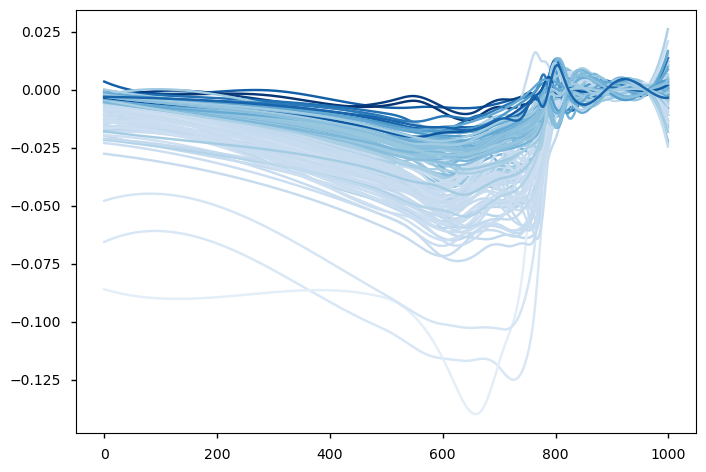

In [299]:
fig,ax=plt.subplots()
colors = plt.cm.Blues(np.linspace(0.1,1,len(bat_dict.keys())))
for id in test.keys():
    ix = int(len(colors)*(test[id]['cycle_life']-150)/(2300-150))
    ax.plot(test[id]["DeltaQ"],color=colors[ix])

## Figures

In [32]:
feature_df.iloc[feature_df["cycle_life"].argmax()] # find battery with longest life

cycle_life                                                   2237.0
DeltaQ_logVars    [1.684583961631894e-05, 4.260115928846763e-05,...
DeltaQ_mins       [-0.020902900546645405, -0.041686279862562986,...
DeltaQ_means      [0.0011126241451828816, 0.0016144215113091736,...
DeltaQ_skews      [-0.9608399692603259, -2.773384264352175, 1.02...
DeltaQ_kurts      [4.903683300977248, 12.248623292108014, 3.3196...
Name: b1c2, dtype: object

In [33]:
feature_df.iloc[feature_df["cycle_life"].argmin()] # find battery with shortest life

cycle_life                                                    148.0
DeltaQ_logVars    [9.56236783000333e-05, 5.072829850287893e-05, ...
DeltaQ_mins       [-0.05950914214118663, -0.04676469583586386, -...
DeltaQ_means      [-0.011045613263006395, -0.006867915599479255,...
DeltaQ_skews      [-1.137926330989971, -0.293695777611634, 0.443...
DeltaQ_kurts      [2.315973121693758, 6.530414358771495, 0.16786...
Name: b2c1, dtype: object

In [90]:
feature_dict["b2c10"]["cycle_life"]

561.0

In [ ]:
plt.style.use("seaborn-v0_8-paper")
from matplotlib import style
# evolution of discharge voltage curves over time
fig,axs = plt.subplots(ncols=2,figsize=(12,5))

def plot_cycles(id,ax,colors):
    for j in range(100,2,-20):
        x,y = crop_data(id,str(j))
        ax.plot(y,x,color=colors[j-1])
        #ax.set_ylim([2.8,3.2])
        #ax.set_xlim([0.9,1.1])
        ax.set_xlabel("Discharge capacity (Ah)")
        ax.set_ylabel("Voltage (V)")

colors = plt.cm.Blues_r(np.linspace(0.1,1,100))
plot_cycles("b2c10",axs[0],colors)
colors = plt.cm.Reds_r(np.linspace(0.1,1,100))
plot_cycles("b2c1",axs[1],colors)
axs[0].set_title("Battery with cycle lifetime 561")
axs[1].set_title("Battery with cycle lifetime 148")
axs[0].arrow(0.95,2.8,-0.15,0,width=0.01)
axs[0].text(0.6,2.7,"Increasing cycle")
axs[1].arrow(0.85,2.8,-0.15,0,width=0.01)
axs[1].text(0.5,2.7,"Increasing cycle")

## Explore other features

(-0.0025, 0.0025)

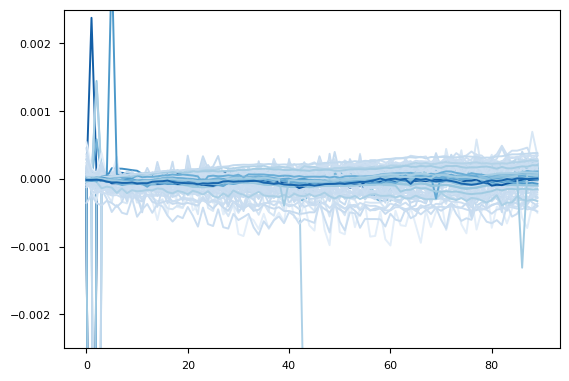

In [54]:
fig,ax=plt.subplots()
colors = plt.cm.Blues(np.linspace(0.1,1,len(bat_dict.keys())))
for id in bat_dict.keys():
    ix = int(len(colors)*(feature_dict[id]['cycle_life']-150)/(2300-150))
    y = bat_dict[id]['summary']["IR"][10:100] - bat_dict[id]['summary']["IR"][9]
    ax.plot(y,color=colors[ix])
ax.set_ylim([-0.0025,0.0025])

## Extract charge policy

In [19]:
# get most used charge rate for each battery
charge_info = {}
for id in bat_dict.keys():
    str = bat_dict[id]["charge_policy"]
    str_split = str.split('C')
    c1 = float(str_split[0])
    c2 = str.split('-')[1]
    if 'C' in c2:
        c2 = float(c2.split('C')[0])
    else:
        c2 = float(c2)
    percent = float(str_split[1].split('%')[0][1:])/100
    #if percent >= 50:
    #    charge_info[id] = c1
    #else:
    #    charge_info[id] = c2
    charge_info[id] = (1/c1)*percent + (1/c2)*(1-percent)

In [20]:
charge_info

{'b1c0': 0.2777777777777778,
 'b1c1': 0.2777777777777778,
 'b1c2': 0.2777777777777778,
 'b1c3': 0.25,
 'b1c4': 0.25,
 'b1c5': 0.22727272727272727,
 'b1c6': 0.20833333333333334,
 'b1c7': 0.20833333333333334,
 'b1c9': 0.24074074074074073,
 'b1c11': 0.25925925925925924,
 'b1c14': 0.24444444444444444,
 'b1c15': 0.24444444444444444,
 'b1c16': 0.2222222222222222,
 'b1c17': 0.2222222222222222,
 'b1c18': 0.22962962962962963,
 'b1c19': 0.22962962962962963,
 'b1c20': 0.18518518518518517,
 'b1c21': 0.18518518518518517,
 'b1c23': 0.24444444444444444,
 'b1c24': 0.26666666666666666,
 'b1c25': 0.26666666666666666,
 'b1c26': 0.23333333333333334,
 'b1c27': 0.23333333333333334,
 'b1c28': 0.25,
 'b1c29': 0.25,
 'b1c30': 0.2222222222222222,
 'b1c31': 0.2222222222222222,
 'b1c32': 0.23333333333333334,
 'b1c33': 0.23333333333333334,
 'b1c34': 0.2373015873015873,
 'b1c35': 0.2373015873015873,
 'b1c36': 0.2571428571428571,
 'b1c37': 0.2571428571428571,
 'b1c38': 0.2238095238095238,
 'b1c39': 0.223809523809523

In [21]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v3.pkl', 'rb'))

In [22]:
for id in bat_dict.keys():
    data[id]["chargetime_policy"] = charge_info[id]

In [24]:
with open('../Data/deltaQ_cycles_v4.pkl','wb') as fp:
    pickle.dump(data,fp)